In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=2, minor=7, micro=15, releaselevel='final', serial=0)

In [2]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import probfit as pf
from iminuit import Minuit
import ROOT

Welcome to JupyROOT 6.16/00


In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
c = ROOT.TCanvas("tt", "Cab", 900, 600)
c.SetGrid()

In [4]:
def style(hist, xtitle="", ytitle=""):
    hist.SetTitle("")
    if(xtitle):
        hist.SetXTitle(xtitle)
        hist.SetYTitle(ytitle)
        hist.SetTitleSize(0.08)
    hist.GetXaxis().SetLabelSize(0.05)
    hist.GetXaxis().SetTitleSize(0.05)
    hist.GetXaxis().SetTitleOffset(0.9)
    hist.GetYaxis().SetLabelSize(0.05)
    hist.GetYaxis().SetTitleSize(0.05)
    hist.GetYaxis().SetTitleOffset(1)
    hist.SetLineWidth(2)
    hist.SetLineColor(2)
    hist.SetLineColor(2)
    return

# Values of the experiment

In [4]:
dt11 = pd.read_csv("../outputs/11/out11.csv", index_col=['Unnamed: 0'])

In [5]:
dt11.head()

,Nsig,dNsig,lum,Emean,dEmax,dEmin
525.0,810.42,29.27,535.7,523.58,0.0,-0.0
537.5,885.56,30.26,612.4,537.41,0.0,-0.0
550.0,379.98,20.27,561.4,548.44,0.0,-0.0
562.5,385.34,20.18,599.9,562.13,-0.0,0.0
575.0,158.11,13.23,569.9,575.31,0.0,-0.0


Number of signal events 2011

In [6]:
dt11.Nsig.sum()

3830.2299999999996

Background 2011

In [7]:
f11 = uproot.pandas.iterate("../outputs/11/*.root", "t")
data11 = pd.concat([j for j in f11])[['label', 'm', 'proc', 't']].query('t>-1&proc!=1&abs(m-500)<50')

In [8]:
np.size(data11.m) - dt11.Nsig.sum()

288.77000000000044

Number of signal events 2012

In [9]:
data12 = pd.read_csv("../outputs/12/out12.csv", index_col=['Unnamed: 0'])
data12.Nsig.sum()

532.83000000000004

In [10]:
f12 = uproot.pandas.iterate("../outputs/12/*.root", "t")
d12 = pd.concat([j for j in f12])[['label', 'm', 'proc', 't']].query('t>-1&proc!=1&abs(m-500)<50')
np.size(d12.m) - data12.Nsig.sum()

97.169999999999959

Number of signal events 2017

In [11]:
data17 = pd.read_csv("../outputs/17/out17.csv", index_col=['Unnamed: 0'])
data17.Nsig.sum()

1269.0199999999998

In [46]:
f17 = uproot.pandas.iterate("../outputs/17/*.root", "t")
d17 = pd.concat([j for j in f17])[['label', 'm', 'proc', 't']].query('t>-1&proc!=1&abs(m-500)<50')
np.size(d17.m) - data17.Nsig.sum()

316.98000000000025

## Exp vs MC

In [12]:
f11 = uproot.pandas.iterate("../outputs/11/*.root", "t")
fMC = uproot.pandas.iterate("../outputs/model/*.root", "t")

In [13]:
data11 = pd.concat([j for j in f11])[['label', 'be', 'm', 't', 'proc', 'len', 'theta']].query('label>549')
dataMC = pd.concat([j for j in fMC])[['label', 'be', 'm', 't', 'proc', 'len', 'theta']].query('label>549')

In [14]:
data11 = data11.query('t>-1&proc!=1&abs(m-500)<50')[['label', 'm', 'len', 'theta']]
dataMC = dataMC.query('t>-1&proc!=1&abs(m-500)<50')[['label', 'm', 'len', 'theta']]

In [15]:
data11.index = data11.label
dataMC.index = dataMC.label

In [16]:
data11.sort_index().head()

,label,m,len,theta
label,,,,
550.0,550.0,493.534363,1.310393,2.210273
550.0,550.0,500.360168,0.330968,0.969202
550.0,550.0,491.668579,2.305939,1.643998
550.0,550.0,506.371521,1.406581,2.032284
550.0,550.0,498.158386,1.143072,2.651720


Join "luminosity" file to experiment

In [17]:
lum = data11.drop('label', axis=1).groupby('label').agg({'m':np.size})
lum.columns= ['lum']

In [18]:
lum.head()

,lum
label,
550.0,400.0
562.5,416.0
575.0,169.0
587.5,187.0
600.0,98.0


In [19]:
dataMC = dataMC.join(lum, how='inner')

In [20]:
dataMC.head()

,label,m,len,theta,lum
label,,,,,
550.0,550.0,492.659088,2.177783,0.896533,400.0
550.0,550.0,491.123444,0.957967,1.350168,400.0
550.0,550.0,506.872498,1.616306,2.036664,400.0
550.0,550.0,499.182709,1.436730,1.264909,400.0
550.0,550.0,495.202667,0.851342,1.685800,400.0


Draw weighted histogram

In [21]:
hist = ROOT.TH1D("Hist", "Title", 100, 450, 550)
hist2 = ROOT.TH1D("Hist2", "Title2", 100, 450, 550)

In [22]:
c = ROOT.TCanvas("tt", "Cab", 900, 600)

In [23]:
hist.Reset()
hist.FillN(np.size(data11.m.values), data11.m.values, np.ones(np.size(dataMC.m)))
hist.Sumw2()
#hist.Scale(np.sum(dataMC.lum*1e-3)/np.size(data11.m))

In [24]:
hist2.Reset()
#hist2.Sumw2()
hist2.FillN(np.size(dataMC.m), dataMC.m.values, dataMC.lum.values*1e-3)
hist2.Scale(np.size(data11.m)/np.sum(dataMC.lum*1e-3))

In [25]:
np.sum(dataMC.lum*1e-3)/np.size(data11.m)

1.260378794356563

In [26]:
plain = ROOT.TStyle("Modern","Plain Style (no colors/fill areas)");
plain.SetOptStat(0)
plain.SetLabelSize(0.05)
plain.SetTitleFontSize(0.05);
ROOT.gROOT.SetStyle("Modern")

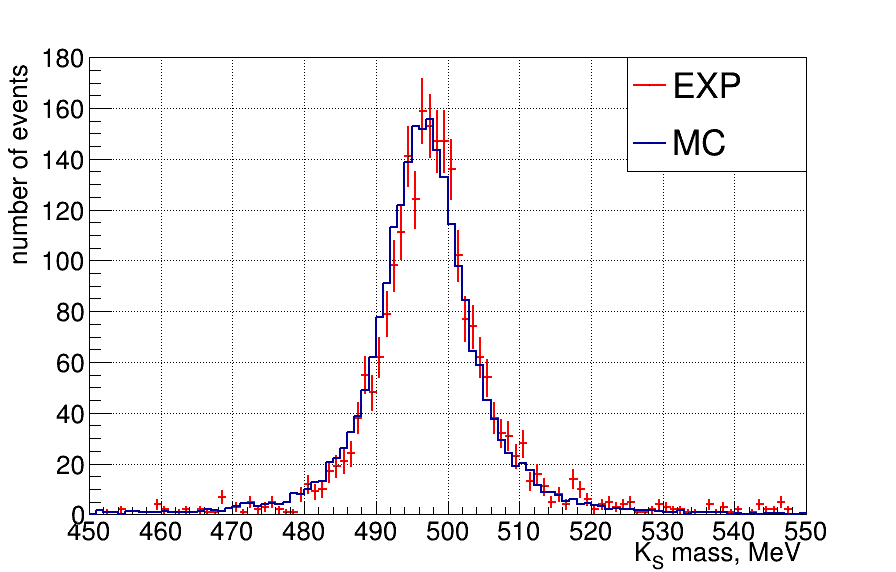

In [28]:
c.Clear()
hist.Draw("")
hist2.Draw("same hist")
style(hist, "K_{S} mass, MeV", "number of events")
#hist.SetTitle("")
#hist.SetXTitle("K_{S} mass, MeV")
#hist.SetYTitle("number of events")
#hist.SetLineWidth(2)
#hist.SetLineColor(2)
hist2.SetLineWidth(2)
leg = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
leg.AddEntry(hist, "EXP")
leg.AddEntry(hist2, "MC")
leg.Draw()
c.SetGrid()
c.Draw()
#c.SaveAs("mc.svg")

### Len

In [54]:
lenExp = ROOT.TH1D("lenExp", "EXP", 20, 0, 10);
lenMC = ROOT.TH1D( "lenMC",  "MC", 20, 0, 10);

Warning in <TROOT::Append>: Replacing existing TH1: lenExp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: lenMC (Potential memory leak).


In [55]:
dtMC = dataMC.loc[850:]
dt11 = data11.loc[850:]

In [56]:
lenExp.Reset()
lenExp.FillN(np.size(dt11.len.values), dt11.len.values, np.ones(np.size(dtMC.len)))

In [57]:
lenMC.Reset()
lenMC.Sumw2();
lenMC.FillN(np.size(dtMC.len), dtMC.len.values, dtMC.lum.values*1e-3)
lenMC.Scale(np.size(dt11.len)/np.sum(dtMC.lum*1e-3))

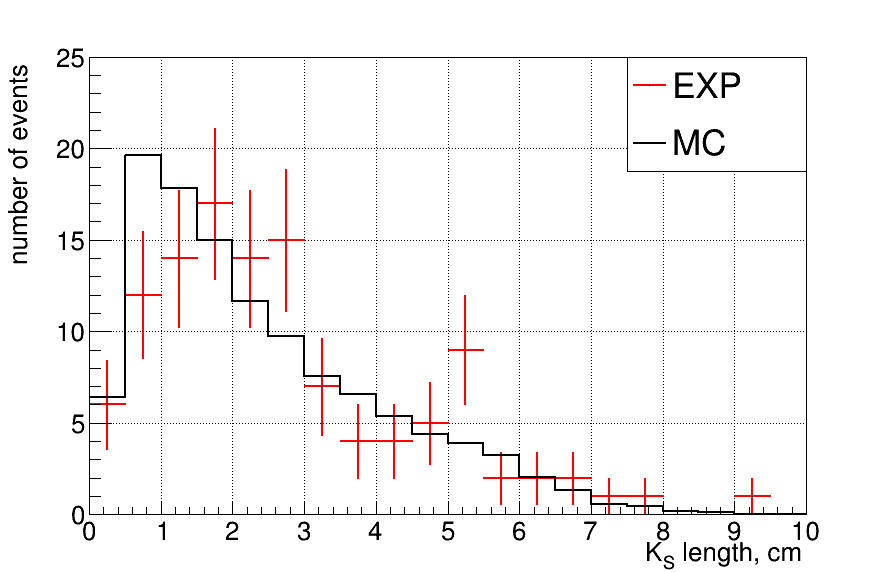

In [61]:
c.Clear()
lenExp.Draw("ep")
lenMC.Draw("same hist")
style(lenExp, "K_{S} length, cm", "number of events")
#lenExp.SetTitle("")
#lenExp.SetXTitle("K_{S} length, cm")
#lenExp.SetYTitle("number of events")
#lenExp.SetLineWidth(2)
#lenExp.SetLineColor(2)
lenMC.SetLineWidth(2)
lenMC.SetLineColor(1)
lenExp.SetAxisRange(0., 25.,"Y");
leg = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
leg.AddEntry(lenExp, "EXP")
leg.AddEntry(lenMC, "MC")
leg.Draw()
c.SetGrid()
c.Draw()
#c.SaveAs("mcLen.svg")

## $K_S$ $\theta$

In [25]:
thExp = ROOT.TH1D("thExp", "EXP", 50, 0, ROOT.TMath.Pi());
thMC = ROOT.TH1D( "thMC",  "MC", 50, 0, ROOT.TMath.Pi());

In [26]:
data11_h = data11#.query('label<610')
dataMC_h = dataMC#.query('label<610')

In [27]:
thExp.Reset()
thExp.FillN(np.size(data11_h.theta.values), data11_h.theta.values, np.ones(np.size(data11_h.theta)))

In [28]:
thMC.Reset()
thMC.Sumw2();
weights = dataMC_h.lum.values*1e-3
thMC.FillN(np.size(dataMC_h.theta), dataMC_h.theta.values, weights)
thMC.Scale(np.size(data11_h.theta)/np.sum(weights))

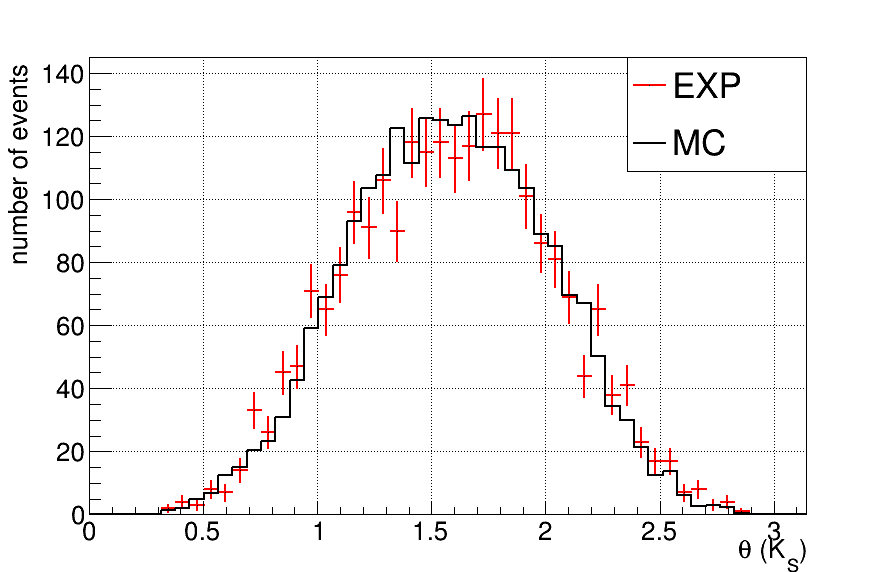

In [29]:
c.Clear()
thExp.Draw("ep")
style(thExp, "#theta (K_{S})", "number of events")
#thExp.SetTitle("#theta distribution of K_{S}")
#thExp.SetXTitle("#theta (K_{S})")
#thExp.SetYTitle("number of events")
#thExp.SetLineWidth(2)
#thExp.SetLineColor(2)
#thExp.SetAxisRange(0., 120.,"Y");

thMC.Draw("same hist")
thMC.SetLineWidth(2)
thMC.SetLineColor(1)

leg = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
leg.AddEntry(thExp, "EXP")
leg.AddEntry(thMC, "MC")
leg.Draw()
c.SetGrid()
c.Draw()
#c.SaveAs("mcTh.svg")

## RegEfficiency

In [5]:
reg11 = pd.read_csv('../outputs/model/outmodel.csv', index_col=['Unnamed: 0'])

In [6]:
reg11.tail()

,Nsig,dNsig,lum,dEmin,dEmax,Emean
945.0,1138.68,37.10,5550,0.0,0.0,945.0
950.0,1124.21,35.84,5294,0.0,0.0,950.0
962.5,994.80,33.73,4667,0.0,0.0,962.5
975.0,846.18,32.03,4113,0.0,0.0,975.0
987.5,738.37,29.64,3640,0.0,0.0,987.5


In [7]:
reg11['eff'] = reg11.Nsig/reg11.lum
reg11['err'] = reg11.eff*np.sqrt( 1/reg11.Nsig + 1/reg11.lum )

In [8]:
histReg = ROOT.TGraphErrors(np.size(reg11.Nsig), reg11.index.values*2e-3, reg11.eff.values, 
                            np.zeros(np.size(reg11.Nsig)), reg11.err.values)

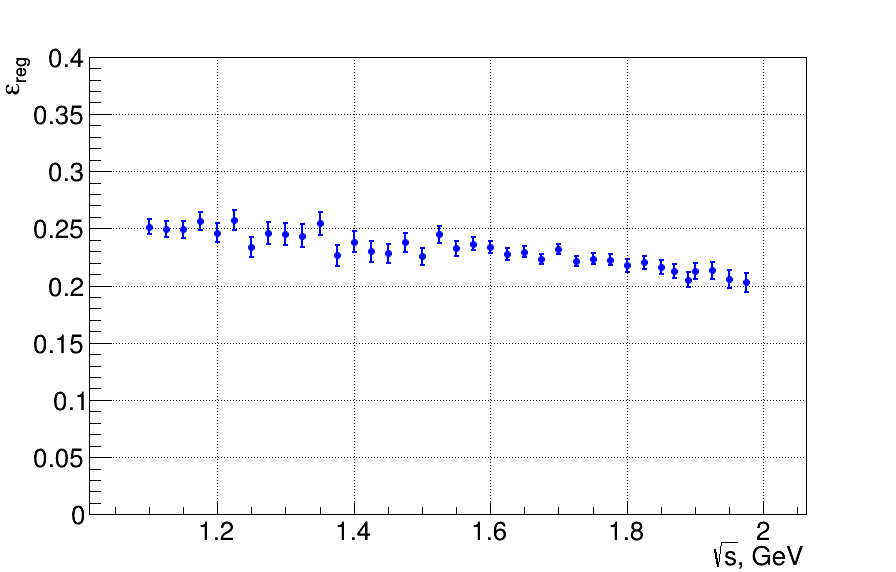

In [9]:
c.Clear()
style(histReg)
histReg.SetLineWidth(2)
histReg.SetTitle(";#sqrt{s}, GeV;#varepsilon_{reg}")
histReg.SetLineColor(4)
histReg.SetMarkerStyle(20)
histReg.SetMarkerSize(0.8)
histReg.SetMarkerColor(4)
histReg.Draw("ap")
histReg.GetYaxis().SetRangeUser(0, 0.4)
c.Draw()
#c.SaveAs("reg_eff.svg")

## Trigger efficiency

In [10]:
trig11 = pd.read_csv('../outputs/11/triggers11.csv')
trig12 = pd.read_csv('../outputs/12/triggers12.csv')
trig17 = pd.read_csv('../outputs/17/triggers17.csv')
trig19 = pd.read_csv('../outputs/19/triggers19.csv')

In [11]:
trig12.head()

,label,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
0,640.0,66.0,0.0,31.0,0.97,0.32,0.98,0.03,0.05,0.02
1,680.0,47.0,2.0,21.0,0.88,0.31,0.92,0.06,0.06,0.04
2,720.0,33.0,2.0,18.0,0.86,0.36,0.91,0.07,0.07,0.05
3,760.0,50.0,1.0,26.0,0.93,0.35,0.95,0.05,0.05,0.03
4,800.0,67.0,2.0,47.0,0.94,0.41,0.97,0.03,0.05,0.02


In [12]:
def trigger_graph(trig):
    eff = ROOT.TGraphErrors(np.size(trig.label), trig.label.values*2e-3, trig.TrigEff.values, 
                            np.zeros(np.size(trig.label)), trig.TrigErr.values)
    tf = ROOT.TGraphErrors(np.size(trig.label), trig.label.values*2e-3, trig.eTF.values, 
                            np.zeros(np.size(trig.label)), trig.vTF.values)
    cf = ROOT.TGraphErrors(np.size(trig.label), trig.label.values*2e-3, trig.eCF.values, 
                            np.zeros(np.size(trig.label)), trig.vCF.values)
    style(cf)
    eff.SetLineWidth(2)
    eff.SetLineColor(4)
    eff.SetMarkerColor(4)
    eff.SetMarkerStyle(20)
    eff.SetMarkerSize(0.8)
    
    tf.SetLineColor(2)
    tf.SetMarkerColor(2)
    tf.SetLineWidth(2)
    tf.SetMarkerSize(0.8)
    tf.SetMarkerStyle(20)
    
    
    cf.GetYaxis().SetRangeUser(0, 1.1)
    cf.SetTitle(";#sqrt{s}, GeV;#varepsilon_{trig}")
    cf.SetMarkerStyle(20)
    cf.SetMarkerSize(0.8)
    cf.SetMarkerColor(3)
    cf.SetLineColor(3)
    
    leg = ROOT.TLegend(0.1, 0.1, 0.3, 0.25)
    leg.AddEntry(eff, "#varepsilon_{trig}")
    leg.AddEntry(tf, "#varepsilon_{TF}")
    leg.AddEntry(cf, "#varepsilon_{CF}")
    
    
    return (eff, tf, cf, leg)

Info in <TCanvas::Print>: SVG file trig11.svg has been created


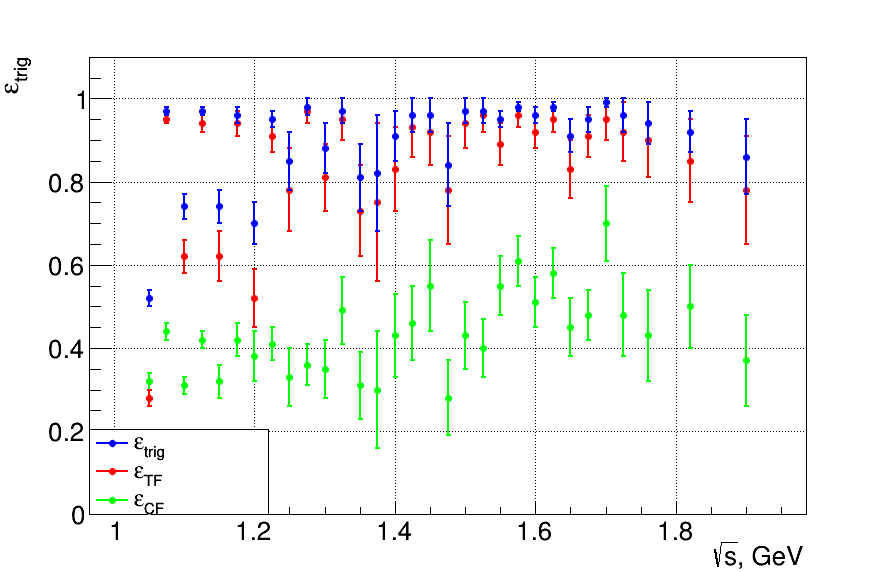

In [86]:
eff, tf, cf, leg = trigger_graph(trig11)
c.Clear()
cf.Draw("ap")
tf.Draw("p same")
eff.Draw("p same")
leg.Draw()
c.Draw()
#c.SaveAs("trig11.svg")

Info in <TCanvas::Print>: SVG file trig12.svg has been created


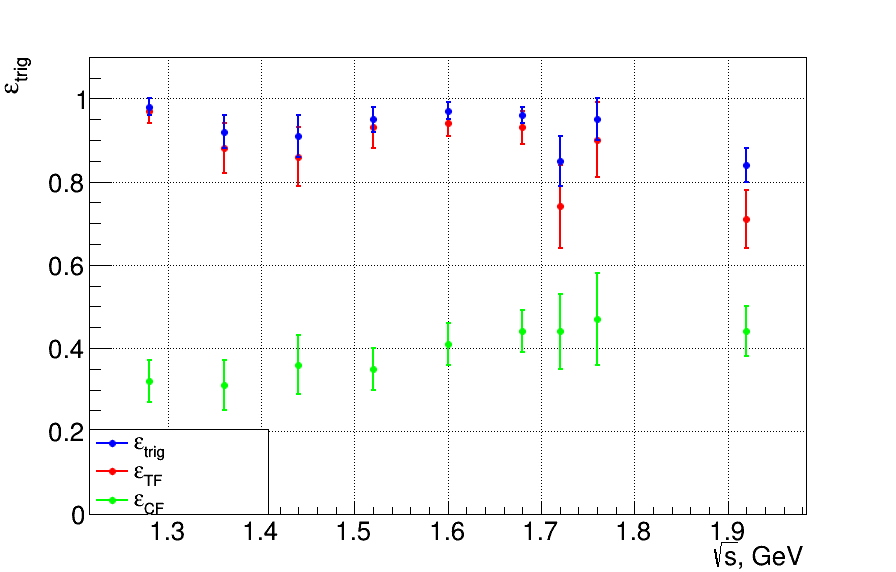

In [88]:
eff, tf, cf, leg = trigger_graph(trig12)
c.Clear()
cf.Draw("ap")
tf.Draw("p same")
eff.Draw("p same")
leg.Draw()
c.Draw()
#c.SaveAs("trig12.svg")

Info in <TCanvas::Print>: SVG file trig17.svg has been created


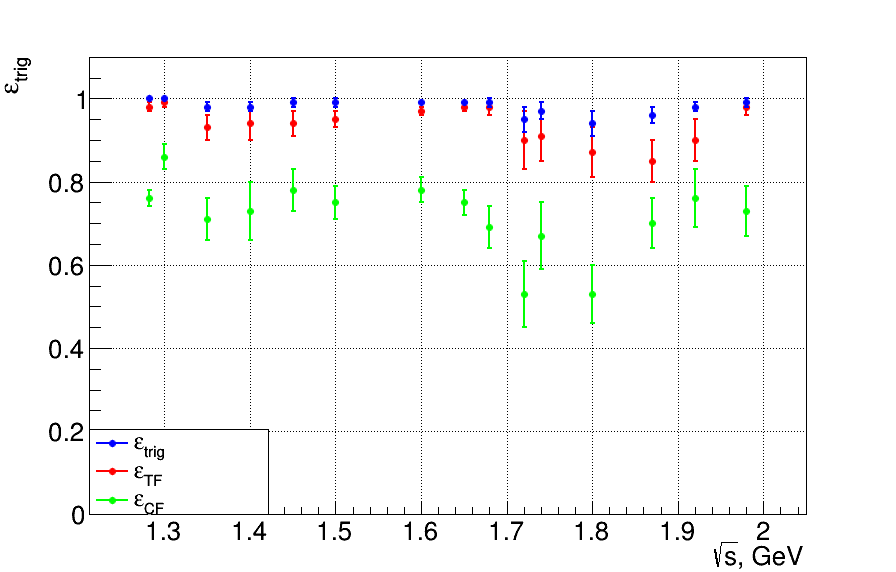

In [90]:
eff, tf, cf, leg = trigger_graph(trig17)
c.Clear()
cf.Draw("ap")
tf.Draw("p same")
eff.Draw("p same")
leg.Draw()
c.Draw()
#c.SaveAs("trig17.svg")

Info in <TCanvas::Print>: SVG file trig19.svg has been created


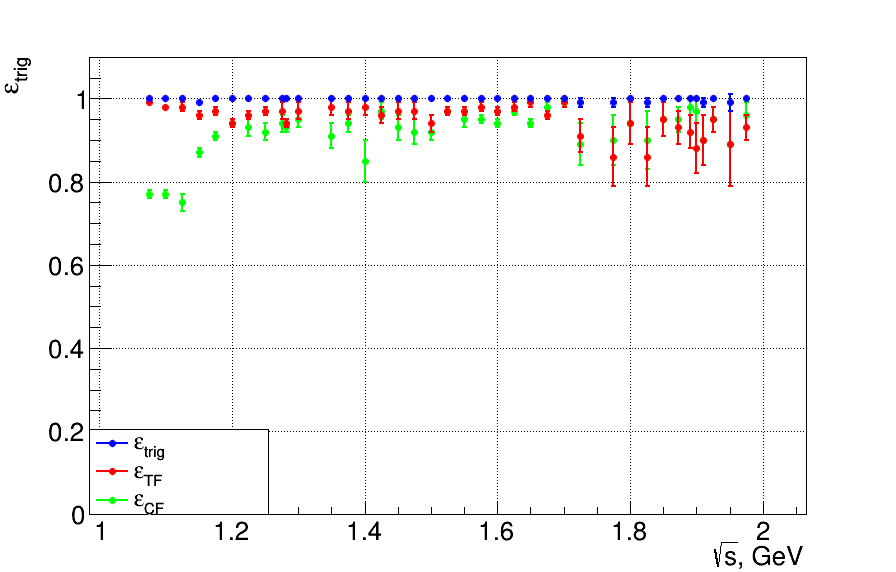

In [14]:
eff, tf, cf, leg = trigger_graph(trig19)
c.Clear()
cf.Draw("ap")
tf.Draw("p same")
eff.Draw("p same")
leg.Draw()
c.Draw()
#c.SaveAs("trig19.svg")

## Rad corrections

In [3]:
rc = pd.read_csv('rad_cors.dat', delimiter='\t', header=None, names=['label', 'rad'])

In [4]:
rc.head()

,label,rad
0,525.0,0.863528
1,540.0,0.861685
2,550.0,0.867511
3,562.5,0.874765
4,575.0,0.881186


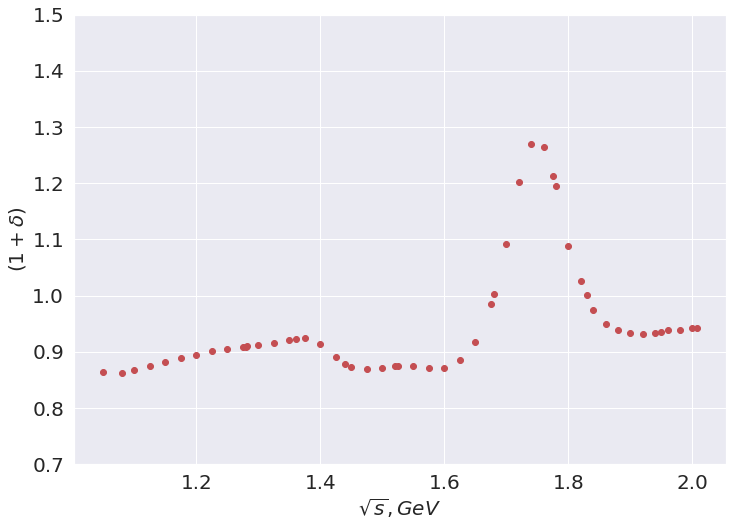

In [20]:
plt.plot(rc.label*2e-3, rc.rad, 'ro')
plt.ylabel("$(1+\delta)$", fontsize=20);
plt.xlabel("$\sqrt{s}, GeV$", fontsize=20);
ax = plt.gca()
ax.set_ylim([0.7,1.5])
plt.tick_params(labelsize=20);
plt.savefig('rad.png', dpi=300)

## Lum

In [36]:
l11 = pd.read_csv('../inputs/17/lum', header=None, names=['en', 'lum'])

In [37]:
l11.query('en>524').lum.sum()

44624.299999999996

In [40]:
l11.sort_values('en').head(8)

,en,lum
31,641.0,3283.2
30,650.0,932.0
29,675.0,1295.2
28,700.0,917.9
27,725.0,1155.9
26,750.0,1138.8
25,775.0,997.9
24,800.0,1271.1


In [39]:
np.size(l11.query('en>524').lum)

32

In [41]:
641*2

1282